# PWL - Lattice

In [1]:
# PWLLattice.py

In [2]:
import os
import sys

# import common
import argparse

# import datasets
import numpy as np
import pandas as pd

from tqdm import tqdm

from matplotlib import pyplot as plt

# import estimators as estimators_lib
import itertools
import tensorflow as tf
import tensorflow_lattice as tfl

from query_func import *
from models import *

/var/folders/x9/rlw36ttd3d9dvskjy8fd9t3r0000gn/T/ipykernel_55758/1248846584.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--dataset", type=str, default="wine2", help="Dataset.")
parser.add_argument("--query-size", type=int, default=100, help="query size")
parser.add_argument("--min-conditions", type=int, default=1, help="min num of conditions")
parser.add_argument("--max-conditions", type=int, default=2, help="max num of conditions")
parser.add_argument("--epochs", type=int, default=10, help="Number of epochs to train for.")
parser.add_argument("--bs", type=int, default=10000, help="Batch size.")
parser.add_argument("--loss", type=str, default="MSE", help="Loss.")
parser.add_argument("--lattice-size", type=int, default=2, help="Lattice size.")
parser.add_argument("--lr", type=float, default=1e-3, help="learning rate")
parser.add_argument("--seed", type=int, default=42, help="Random seed")

try:
    args = parser.parse_args()
except:
    # args = parser.parse_args([])
    args, unknown = parser.parse_known_args()

usage: ipykernel_launcher.py [-h] [--dataset DATASET]
                             [--query-size QUERY_SIZE]
                             [--min-conditions MIN_CONDITIONS]
                             [--max-conditions MAX_CONDITIONS]
                             [--epochs EPOCHS] [--bs BS] [--loss LOSS]
                             [--lattice-size LATTICE_SIZE] [--lr LR]
                             [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/chun/Library/Jupyter/runtime/kernel-v2-54065WOxaY6oNweVL.json


In [4]:
def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


OPS = {">": np.greater, "<": np.less, ">=": np.greater_equal, "<=": np.less_equal, "=": np.equal}
FilePath = (
    f"{args.dataset}_{args.query_size}_{args.min_conditions}_{args.max_conditions}_{args.loss}"
)
resultsPath = f"results/{FilePath}"
modelPath = f"saved_models/{FilePath}"
make_directory(resultsPath)
make_directory(modelPath)

In [5]:
# n_row, n_column 要被table_size 取代

In [6]:
print("Begin Loading Data ...")
print(f"{args.dataset}.csv")
table = np.loadtxt(f"datasets/{args.dataset}.csv", delimiter=",")
np.savetxt(f"{resultsPath}/original_table.csv", table, delimiter=",")
print("Done.\n")

print("Begin Generating Queries Set...")
table_size = table.shape
n_row, n_column = table_size
rng = np.random.RandomState(args.seed)
query_set = [
    generate_random_query(table, args.min_conditions, args.max_conditions + 1, rng)
    for _ in tqdm(range(args.query_size))
]
print("Done.\n")
print("Begin Intervalization ...")
unique_intervals = column_intervalization(table_size, query_set)
unique_intervals
column_interval_number = count_column_unique_interval(unique_intervals)
print(f"{column_interval_number=}")
print("Done.\n")

Begin Loading Data ...
wine2.csv
Done.

Begin Generating Queries Set...


100%|██████████| 100/100 [00:00<00:00, 14294.05it/s]

Done.

Begin Intervalization ...
column_interval_number=[35, 42]
Done.



In [7]:
# table = datasets.LoadDataset(f"datasets/{args.dataset}.csv", args.dataset)

# print("Begin Generating Queries Set...")
# rng = np.random.RandomState(args.seed)
# query_set = [
#     GenerateQuery(table, args.min_conditions, args.max_conditions + 1, rng, args.dataset)
#     for _ in tqdm(range(args.query_size))
# ]
# print("Done.\n")


# table_size = table.data.shape
# n_row = table_size[0]
# n_column = table_size[1]
# print("Begin Intervalization ...")
# unique_intervals = dictionary_column_interval(table_size, query_set)
# column_interval_number = count_column_unique_interval(unique_intervals)
# print("Done.\n")
# print(column_interval_number)

In [8]:
# 修改 x = [sys.maxsize] * n_column     # 这里使用每个col_unique_interval的最后一个元素即可
# 如果使用两个input的话，一个修改为最大，一个修改为最小
train_X = []
for query in query_set:
    x = [sys.maxsize] * n_column  # 这里使用每个col_unique_interval的最后一个元素即可
    idxs, _, vals, _ = query
    for i in range(len(idxs)):
        x[idxs[i]] = vals[i]
    train_X.append(x)
train_X = np.array(train_X).astype(np.float32)
train_Y = np.array([[query[-1]] for query in query_set], dtype=np.float32)

In [9]:
# train_X = []
# train_Y = []
# for query in query_set:
#     x = [sys.maxsize] * n_column  # 这里使用每个col_unique_interval的最后一个元素即可
#     _, idxs, _, vals, sel = query
#     for i in range(len(idxs)):
#         x[idxs[i]] = vals[i][0]
#     train_X.append(x)
#     train_Y.append(sel)

# train_X = np.array(train_X).astype(np.float32)
# train_Y = np.array(train_Y).astype(np.float32).reshape(-1, 1)

In [10]:
# make train set unique
# train = np.concatenate((train_X, train_Y), axis=1)
# train = np.unique(train, axis=0)
# train_X, train_Y = np.hsplit(train, [-1])

In [11]:
# 可以PWL改成三次样条吗

In [12]:
m = PWLLattice(
    modelPath,
    table_size,
    unique_intervals,
    pwl_keypoints=None,
    lattice_size=args.lattice_size,
)

2024-06-12 18:01:19.948743: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-12 18:01:19.948779: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-12 18:01:19.948785: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-12 18:01:19.948857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-12 18:01:19.949029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 col_0 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 col_1 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 pwl_calibration (PWLCalibr  (None, 1)                    35        ['col_0[0][0]']               
 ation)                                                                                           
                                                                                                  
 pwl_calibration_1 (PWLCali  (None, 1)                    42        ['col_1[0][0]']           

In [13]:
m.fit(train_X, train_Y, lr=args.lr, bs=args.bs, epochs=args.epochs, loss=args.loss)

Epoch 1/10


2024-06-12 18:01:21.267582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 0.0365
Epoch 1: loss improved from inf to 0.03646, saving model to saved_models/wine2_100_1_2_MSE/PWLLattice_weight.h5
1/1 [==============================] - 1s 1s/step - loss: 0.0365 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.0309
Epoch 2: loss improved from 0.03646 to 0.03089, saving model to saved_models/wine2_100_1_2_MSE/PWLLattice_weight.h5
1/1 [==============================] - 0s 56ms/step - loss: 0.0309 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.0269
Epoch 3: loss improved from 0.03089 to 0.02694, saving model to saved_models/wine2_100_1_2_MSE/PWLLattice_weight.h5
1/1 [==============================] - 0s 53ms/step - loss: 0.0269 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.0242
Epoch 4: loss improved from 0.02694 to 0.02424, saving model to saved_models/wine2_100_1_2_MSE/PWLLattice_weight.h5
1/1 [================

INFO:tensorflow:Assets written to: saved_models/wine2_100_1_2_MSE/PWLLattice_model/assets


In [14]:
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)  # 所有 unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)

In [15]:
m.load()
grid_pred = m.predict(grid)

46/46 [==============================] - 0s 5ms/step


In [16]:
dataNew = m.generate(grid, grid_pred)
np.savetxt(f"{resultsPath}/generated_table.csv", dataNew, delimiter=",")
Q_error = calculate_Q_error(dataNew, query_set, table_size)
print_Q_error(Q_error, args, resultsPath)

Begin Generating Table ...


100%|██████████| 1470/1470 [00:00<00:00, 90439.56it/s]


Done.

Begin Calculating Q-error ...


100%|██████████| 100/100 [00:00<00:00, 43253.62it/s]

Done.

dataset=wine2, query size=100, condition=[1, 2], loss=MSE):

           Q-error
min       1.006849
10        1.052350
20        1.095652
30        1.163914
40        1.225180
median    1.251805
60        1.280123
70        1.491699
80        1.798297
90        2.303123
95        6.379262
99      113.578333
max     121.333333
mean      4.386888


In [17]:
dataNew.shape, table_size

((5077, 2), (6497, 2))

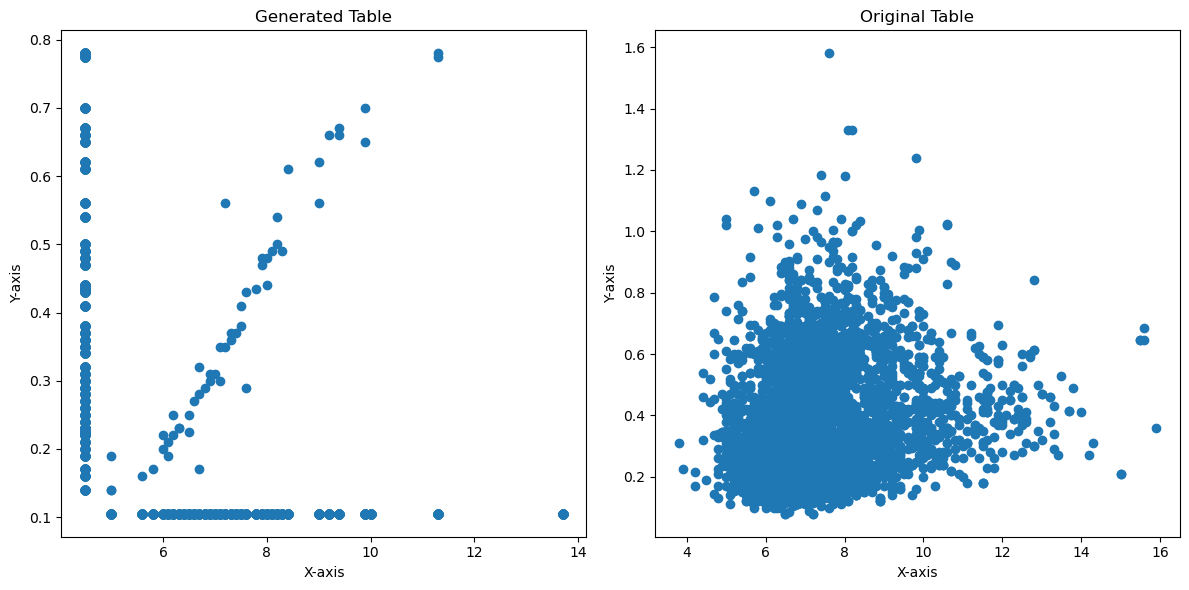

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(dataNew[:, 0], dataNew[:, 1], "o")
axs[0].set_title("Generated Table")
axs[0].set_xlabel("X-axis")
axs[0].set_ylabel("Y-axis")

axs[1].plot(table[:, 0], table[:, 1], "o")
axs[1].set_title("Original Table")
axs[1].set_xlabel("X-axis")
axs[1].set_ylabel("Y-axis")
plt.tight_layout()
plt.show()

### generate_from_batches

In [19]:
# 确认一下，下面 batch生成的数组格式和grid 的格式是否是相同的，shape

In [20]:
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)

In [21]:
def _generate_grid_batches(values, batch_size):
    iterator = itertools.product(*values)
    while True:
        batch = list(itertools.islice(iterator, batch_size))
        if not batch:
            break
        yield np.array(batch).astype(np.float32)

In [22]:
values = [v for v in unique_intervals.values()]
total_combinations = np.prod([len(v) for v in values])
batch_size = 10000
processed_batches = []
for batch in tqdm(
    _generate_grid_batches(values, batch_size), total=(total_combinations // batch_size) + 1
):
    processed_batches.append(batch)

final_array = np.vstack(processed_batches)

100%|██████████| 1/1 [00:00<00:00, 1149.44it/s]


In [23]:
assert grid.shape == final_array.shape

In [24]:
assert (final_array == grid).sum() == np.prod(grid.shape)

In [28]:
dataNew = m.generate_6(unique_intervals, batch_size=10000)
np.savetxt(f"{resultsPath}/generated_table.csv", dataNew, delimiter=",")
Q_error = calculate_Q_error(dataNew, query_set, table_size)
print_Q_error(Q_error, args, resultsPath)

Begin Generating Table from Batches (batch_size=10000) ...


  0%|          | 0/1 [00:00<?, ?it/s]

46/46 [==============================] - 0s 6ms/step


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Done.

Begin Calculating Q-error ...


100%|██████████| 100/100 [00:00<00:00, 39078.58it/s]

Done.

dataset=wine2, query size=100, condition=[1, 2], loss=MSE):

           Q-error
min       1.006849
10        1.052350
20        1.095652
30        1.163914
40        1.225180
median    1.251805
60        1.280123
70        1.491699
80        1.798297
90        2.303123
95        6.379262
99      113.578333
max     121.333333
mean      4.386888


In [26]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### 测试简单分布中，使用generate是否能得到正确的分布

In [ ]:
data = np.array([[2, 9], [5, 4], [3, 1], [9, 3], [2, 9], [2, 9], [3, 10], [9, 1], [10, 1], [10, 1]])
values = [range(1, 11), range(1, 11)]
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
results = []
df = pd.DataFrame(data, columns=["x", "y"])
for x in range(1, 11):
    for y in range(1, 11):
        count = df[(df["x"] <= x) & (df["y"] <= y)].shape[0]
        results.append(count)
pred = np.array(results).reshape(-1, 1) / df.shape[0]

In [ ]:
n_row = df.shape[0]
n_column = df.shape[1]

In [ ]:
def generate_5(grid, pred=None):
    # numpy / calculate_query_cardinality_numpy / np.concatenate
    # generate by row, one query may generate several rows
    print("Begin Generating Table ...")
    count = 0
    ArrayNew = None
    ops = ["<="] * n_column
    pred = (pred * n_row).astype(int)  # Case 1: change 0.8 to 0, 1.8 to 1
    for i in tqdm(range(grid.shape[0])):
        vals = grid[i]
        card = pred[i, 0] - calculate_query_cardinality(ArrayNew, ops, vals)
        if card >= 1:
            array3 = np.repeat(vals, card).reshape(self.n_column, card).T
            ArrayNew = array3 if ArrayNew is None else np.concatenate((ArrayNew, array3), axis=0)
            count += card
            if count > n_row:
                print(
                    f"Reached table max row length({n_row}) in {i}-th row of grid with grid value of {vals}, stop generation."
                )
                break
    else:
        print("Done.\n")
        # if count < n_row:
        #     print(
        #         f"Generated table row length({count}) is less than the original table row length({n_row})."
        #     )
        #     # 如果不足,补系统最大值吗？
        return ArrayNew
    return ArrayNew[:n_row, :]

In [ ]:
dataNew = generate_5(grid, pred)
dataNew

In [ ]:
dataNew.plot(kind="scatter", x="col_0", y="col_1", alpha=0.5)

#### 为什么 kl散度是负数，修改 epoch为一个很小的值，看看是否会出现负数

In [ ]:
# 可能与网络的初始化输出值有关？
# 使用 kl散度是否时正确的，如何使用神经网络进行最大似然估计，似然与kl散度之间的关系是什么？

In [ ]:
def some(a):
    b = 9
    return a + b

In [ ]:
some(3)

In [ ]:
grid_pred

In [ ]:
train_X

In [ ]:
train_X.shape

In [ ]:
train_Y.shape

In [ ]:
m.predict(train_X)

In [ ]:
# 2024/06/06 update
## 计算 Q-error 的速度：calculate_Q_error > calculate_Q_error_old, 二者的准确性相同, 目前的速度已经很快了
## 生成表的速度：generate_3 > generate > generate_2，之后考虑用numpy的concatenate来替代pd的concat，进一步提升生成速度，第二个思路：如果采用 auto regressive 模型,按列生成是否可以借助 gpu 来加速，
## 生成表的准确性：generate = generate_2 约等于 generate_3(有时候高，有时候低，误差不大，0.1与0.09999999的差别)

# 画图

In [ ]:
# 把plot 整合到 lattice里，或者单独写几个函数

In [ ]:
grid_pred = m.predict(grid)

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(grid_pred, "bo")

In [ ]:
fig1 = plt.figure(figsize=(15, 8))
ax1 = plt.axes(projection="3d")

# xx = unique_intervals[1]
# yy = unique_intervals[0]
# X, Y = np.meshgrid(xx, yy)

X = grid[:, 1].reshape(column_interval_number[0], column_interval_number[1])  # 这样也可以
Y = grid[:, 0].reshape(column_interval_number[0], column_interval_number[1])
Z = grid_pred.reshape(column_interval_number[0], column_interval_number[1])

ax1.plot_surface(X, Y, Z, cmap="viridis")
plt.show()

In [ ]:
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap="viridis")

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # 这个是啥

cbar = fig2.colorbar(cs)  # 让colorbar细粒度更高一点
plt.show()

In [ ]:
# 画一下原生的图做对比，是否需要更光滑
# 变得光滑：
# 1. 数据预处理，缩放，标准化
# 2. 凸函数
# 3. lattice正则器

In [ ]:
# query 对网格的覆盖率 散点图
fig4 = plt.figure(figsize=(10, 10))
xtick = unique_intervals[0]
ytick = unique_intervals[1]
plt.scatter(train_X[:, 0], train_X[:, 1], c="b")
plt.vlines(xtick, min(ytick), max(ytick), colors="green")
plt.hlines(ytick, min(xtick), max(xtick), colors="green")
plt.show()

# Lattice 其它尝试

In [ ]:
# 对比，对query做unique 和 不做unique的误差

In [ ]:
# 对比传入table unique value 和 只传入 unique_intervals的模型优化效果

In [ ]:
# table unique value
data = table.data.to_numpy()
unique_vals = []
for i in range(data.shape[1]):
    unique_vals.append(np.unique(data[:, i]))

In [ ]:
unique_vals

# 尝试 tfl.configs.FeatureConfig

In [ ]:
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.01

In [ ]:
# feat_mins = train_X.min(axis=0)
# feat_maxs = train_X.max(axis=0)
train = np.concatenate((train_X, train_Y), axis=1)
train = np.unique(train, axis=0)
train_X, train_Y = np.hsplit(train, [-1])
df_train = pd.DataFrame(train, columns=[f"col_{i}" for i in range(train.shape[1] - 1)] + ["sel"])

In [ ]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=df_train,
    y=df_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    shuffle=False,
)

# feature_analysis_input_fn is used for TF Lattice estimators.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=df_train,
    y=df_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

In [ ]:
feature_columns = [
    tf.feature_column.numeric_column("col_0"),
    tf.feature_column.numeric_column("col_1"),
    tf.feature_column.numeric_column("col_2"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="col_0",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
    ]
)
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)

In [ ]:
from IPython.core.pylabtools import figsize

In [ ]:
def save_and_visualize_lattice(tfl_estimator):
    saved_model_path = tfl_estimator.export_saved_model(
        "/tmp/TensorFlow_Lattice_101/",
        tf.estimator.export.build_parsing_serving_input_receiver_fn(
            feature_spec=tf.feature_column.make_parse_example_spec(feature_columns)
        ),
    )
    model_graph = tfl.estimators.get_model_graph(saved_model_path)
    figsize(8, 8)
    tfl.visualization.draw_model_graph(model_graph)
    return model_graph


_ = save_and_visualize_lattice(tfl_estimator)

In [ ]:
def query_to_lattice_input(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    x = [sys.maxsize] * n_column
    for i in range(n_column):
        column_interval[i] = set(
            [0, sys.maxsize]
        )  # use set([0, sys.maxsize]) to adapt '>' and '<'.
    for query in query_set:
        col_idxs = query[1]
        vals = query[3]
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        if not v:
            column_interval[k] = [0]
        else:
            column_interval[k] = sorted(list(v))
    return column_interval